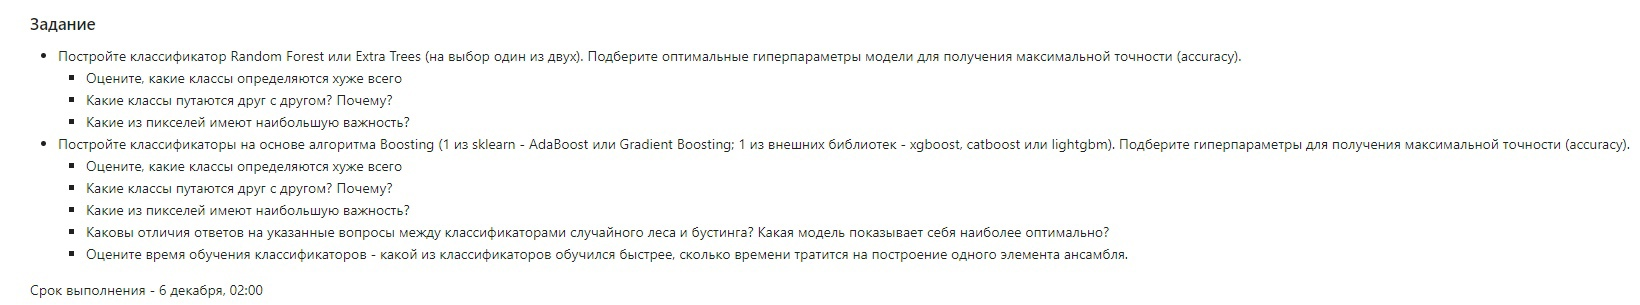

#**Installations and imports**

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import seaborn as snus
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [ ]:
# import packages 
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# download the data:
!wget  https://www.dropbox.com/s/6ynody8xw0h0gyz/train.csv -O mnist_train.csv

--2021-12-17 23:33:59--  https://www.dropbox.com/s/6ynody8xw0h0gyz/train.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6ynody8xw0h0gyz/train.csv [following]
--2021-12-17 23:33:59--  https://www.dropbox.com/s/raw/6ynody8xw0h0gyz/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3067a520af8d00ba49b86d11ce.dl.dropboxusercontent.com/cd/0/inline/BcB7Brjj2xMP4QwXEL73UAyFDkL0pvqZmrIm_PtaV5HmaeABDMDDQIJOCdu2hGo1GtuntXtA9z6laY25HCT-Oif04KIAA00t7IgQ4WEyrJpkjspRuheTtrLpBVdA-1OYTshvGje37iuEy8xRzHDRZVVa/file# [following]
--2021-12-17 23:33:59--  https://uc3067a520af8d00ba49b86d11ce.dl.dropboxusercontent.com/cd/0/inline/BcB7Brjj2xMP4QwXEL73UAyFDkL0pvqZmrIm_PtaV5HmaeABDMDDQIJOCdu2hGo1GtuntXtA9z6laY25HCT-Oif04KIAA00t7Ig

# **Functions of evaluation**

In [ ]:
def get_score(y_test, y_pred, y_prob, multiclass=False):
  multi_class = 'ovo'
  if not multiclass:
    y_prob = y_prob[:,1]
    multi_class = 'raise'
  return {
      'accuracy': accuracy_score(y_test, y_pred),
      'recall': recall_score(y_test, y_pred, average='macro'),
      'precision': precision_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)),
      'f1': f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)),
      'roc_auc': roc_auc_score(y_test, y_prob, average='macro', multi_class = multi_class)
    }

In [ ]:
def print_score_table(X_test, y_test, models, multiclass=False):
  data = []
  for model_instance, model_name, time in [model.values() for model in models]:
    score = get_score(y_test, model_instance.predict(X_test), model_instance.predict_proba(X_test), multiclass)
    data.append([model_name, time, score['accuracy'], score['f1'], score['precision'], score['recall'], score['roc_auc']])

  results_df = pd.DataFrame(data=data, 
                          columns=['Model', 'Time (min)', 'accuracy', 'f1', 'precision', 'recall', 'roc_auc'])
  return results_df

In [ ]:
def print_confusion_matrix(y_test, y_pred):
  result = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix:')
  print(result)
  result1 = classification_report(y_test, y_pred)
  print('Classification Report:',)
  print (result1)
  result2 = accuracy_score(y_test,y_pred)
  print('Accuracy:',result2)

#**Task 1**



The challenge is to build an optimal model for multiclass classification, as we can see from the data:

## **Loading data**

In [ ]:
data = pd.read_csv('/content/mnist_train.csv')
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_train = data
X = data_train.drop('label',axis=1) # Independet variable
y = data_train['label'] # Dependent variable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=23)
y_train

10548    7
28398    5
12831    3
25488    8
4943     3
        ..
9704     8
11190    6
26569    8
9256     5
41555    4
Name: label, Length: 33600, dtype: int64

In [ ]:
y_train_fixed = np.empty((y_train.shape[0], 10))
for ind, digit_ind in enumerate(y_train.values):
    new_row = np.zeros(10)
    new_row[digit_ind] = 1
    y_train_fixed[ind] = new_row

In [ ]:
y_test_fixed = np.empty((y_test.shape[0], 10))
for ind, digit_ind in enumerate(y_test.values):
    new_row = np.zeros(10)
    new_row[digit_ind] = 1
    y_test_fixed[ind] = new_row

In [ ]:
new_data = { 'x_train': X_train, 'y_train': y_train,
            'y_train_acc': y_train_fixed, 'x_test': X_test,
            'y_test': y_test,
            'y_test_acc': y_test_fixed}

## **Problem with tuning parameters**

To find the optimal hyperparameters for our models: **Random Forest, Gradient Boosting and XGBoost** - we first decided to use **GridSearchSV**, because it is the easiest to use. 

But two problems were identified:


1.   the learning process was **very long**, so it is difficult to get an optimal result
2.   **the probability** that we actually get the optimal values ​​of the parameters is *really small*, since the search for hyperparameters is carried out over the grid.



Then, as in laboratory work earlier, we resorted to the **Hyperband** library, which is an add-on to the ([**Hyperopt**](https://https://github.com/hyperopt/hyperopt)) library based on the idea of ​​finding hyperparameters using *Bayesian optimization*.
However, the problem of long training was not solved, although we solved the second problem.

To optimize the learning process and make it not so long (more 20 for each model) We rewrote the **Hyperband** library, breaking the whole learning process into **threads and making backups**. It helped and the learning process became less time consuming (roughly 7-8 hours).

You can find an improved version of the library in the [GitHub repository](https://github.com/mbogomazov/hyperband_multithreading)

In [ ]:
!git clone https://github.com/mbogomazov/hyperband_multithreading

Cloning into 'hyperband_multithreading'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 353 (delta 203), reused 353 (delta 203), pack-reused 0
Receiving objects: 100% (353/353), 11.55 MiB | 10.41 MiB/s, done.
Resolving deltas: 100% (203/203), done.


In [ ]:
from hyperband_multithreading.hyperband import Hyperband

## **RandomForestClassifier** with hyperband

In [ ]:
from hyperband_multithreading.models.classification.rf import HBRandomForestClassifier

In [ ]:
rf = HBRandomForestClassifier(new_data)

In [ ]:
hb_rf = Hyperband(rf)

We start the search for optimal solutions. Since we trained all this before, we recorded the results of the model in the appropriate files. let's see what we have:

In [ ]:
results_rf = hb_rf.run('rf_backup.bck')

Let's see the results:

In [ ]:
!wget https://www.dropbox.com/s/9kekx2gr2y9q2rc/results_rf.pckl

--2021-12-17 23:34:21--  https://www.dropbox.com/s/9kekx2gr2y9q2rc/results_rf.pckl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9kekx2gr2y9q2rc/results_rf.pckl [following]
--2021-12-17 23:34:21--  https://www.dropbox.com/s/raw/9kekx2gr2y9q2rc/results_rf.pckl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5f3badc47d9ba4318503d233c2.dl.dropboxusercontent.com/cd/0/inline/BcC2gP_d3esN-qrSW4-Ovyi2tDTDCKzC1yoeLLIx0U67MqGZtRLCpu195xfJe9gm863pQC3Yb0uFzgTaPv37JlfJ6OX1Tm4bD9feaBVToRgXnPLw5_Q98RAs2aBi5QOHx5i4r-Hr2NYJLCfHN9rTHdKp/file# [following]
--2021-12-17 23:34:22--  https://uc5f3badc47d9ba4318503d233c2.dl.dropboxusercontent.com/cd/0/inline/BcC2gP_d3esN-qrSW4-Ovyi2tDTDCKzC1yoeLLIx0U67MqGZtRLCpu195xfJe9gm863pQC3Yb0uFzgTaP

In [ ]:
with open('/content/results_rf.pckl', 'rb') as f:
                results_rf = pickle.load(f)

Let's find the best result obtained by minimizing the loss function

In [ ]:
rf_hb = min(results_rf, key=lambda x: x['loss'])
rf_hb

{'auc': 0.99348023754425,
 'counter': 86,
 'iterations': 3.0,
 'log_loss': 0.35041987986947715,
 'loss': 0.35041987986947715,
 'params': {'bootstrap': True,
  'class_weight': 'balanced_subsample',
  'criterion': 'entropy',
  'max_depth': 9,
  'max_features': None,
  'min_samples_leaf': 2,
  'min_samples_split': 17},
 'seconds': 60}

Аs we can see the time spent on training such a model with these parameters will take **60 seconds.** But this time is for 5 threads. For usual training process it takes abot **10 min:**

In [ ]:
rf = RandomForestClassifier(**rf_hb['params'])

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features=None, min_samples_leaf=2,
                       min_samples_split=17)

In [ ]:
y_rf_pred = rf.predict(X_test)

In [ ]:
get_score(y_test, y_rf_pred, rf.predict_proba(X_test), multiclass = True)

{'accuracy': 0.9213095238095238,
 'f1': 0.9205446790720389,
 'precision': 0.9211369051738816,
 'recall': 0.9202850230899718,
 'roc_auc': 0.9953701160095068}

## **RandomForestClassifier** with hyperopt

Also, earlier, we trained a random forest and found  directly through the Hoperopt library:

In [ ]:
# standardize the feature variables 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
space = {
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
}

In [ ]:
# define objective function

def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, X_scaled, y,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

here are the results we got:

In [ ]:
# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=None,
    trials_save_file='/content/backup_trials.bck'
)

print("Best: {}".format(best))

100%|██████████| 50/50 [4:35:12<00:00, 516.02s/trial, best loss: -0.9646428571428572]
Best: {'criterion': 1, 'max_depth': 15.0, 'n_estimators': 5}


This means that the value of our accuracy is: **0.9646428571428572**

The optimal hyperparameters are:


1.   **criterion** = 'entropy'
2.   **n_estimators** = 600
3.   **max_depth** = 15

The time spent finding the hyperparameters was: **4:35:12**, but actually, it spent about 10 hours.

Time spent training approximately each iteration: **516.02s/trial**


Check the results:

In [ ]:
clf = RandomForestClassifier(max_depth=15, n_estimators=600, criterion = 'entropy' )
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=600)

The amount of time that was spent training this model was **5 minutes**

In [ ]:
y_p=clf.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_p)

0.9647619047619047

All right! And it is quite better, than accuracy before.

## **Evaluation**

Now, let's check the metric scores:

In [ ]:
get_score(y_test, y_p, clf.predict_proba(X_test), multiclass = True)

{'accuracy': 0.9647619047619047,
 'f1': 0.9645928705898296,
 'precision': 0.9646218582683652,
 'recall': 0.9645979976975599,
 'roc_auc': 0.998981851543723}

In [ ]:
print_confusion_matrix(y_test, y_p)

Confusion Matrix:
[[838   0   1   1   1   0   6   0   5   1]
 [  0 909   3   3   1   1   3   2   2   0]
 [  3   3 822   2   3   1   4  12   5   2]
 [  1   1  10 835   0   7   3  11   6   5]
 [  1   1   2   0 777   1   5   0   4  19]
 [  3   1   0   8   0 721   6   1   1   3]
 [  5   0   0   0   1   6 821   0   4   0]
 [  0   4  10   0   3   0   0 825   2  14]
 [  1   4   3   6   4   7   2   2 752  10]
 [  3   0   0  16  14   2   0   6   2 804]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       853
           1       0.98      0.98      0.98       924
           2       0.97      0.96      0.96       857
           3       0.96      0.95      0.95       879
           4       0.97      0.96      0.96       810
           5       0.97      0.97      0.97       744
           6       0.97      0.98      0.97       837
           7       0.96      0.96      0.96       858
           8       0.96      0.95      0.

### Confusion matrics

Based on the data of the **Confusion Matrix**, we can say that the classes are confused with each other:

*   3, 4, and 9
*   7 and 2
*   7, 8 and 9
*   2 and 3







because the value of the corresponding rows and columns in the Confusion Matrix is large enough compared to the rest of the cells, except for the main diagonal. This means that these are errors: false negative and false positive



Every set of elements that are confused are close enough to each other in spelling, because 2 and 3 have a similar shape on top, such as 7 and 2.

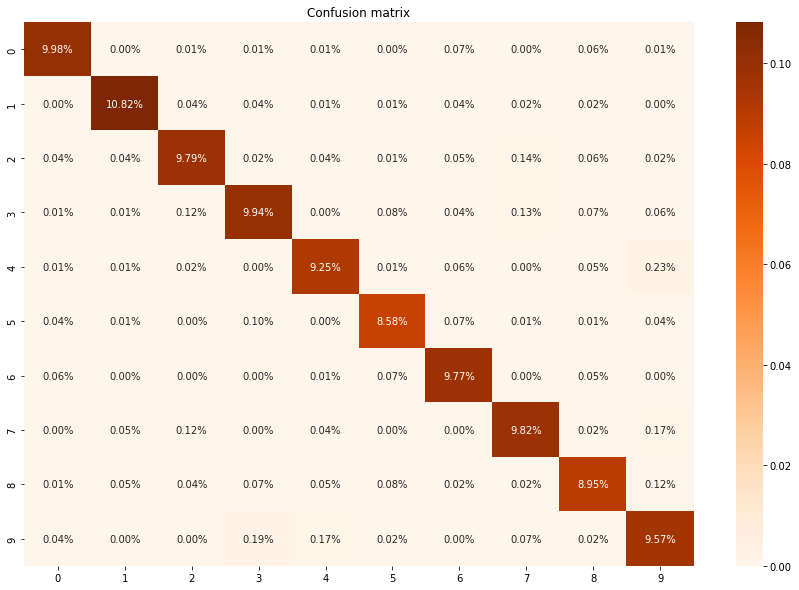

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
snus.heatmap(confusion_matrix(y_test, y_p)/np.sum(confusion_matrix(y_test, y_p)), annot=True, 
            fmt='.2%', cmap='Oranges')
plt.title('Confusion matrix')
plt.show()

### Classification Report

Based on the **Classification Report**, we can say that classes are worst predicted:

*   9, 3, and 8,

since the metric values for these classes are minimal. as we can see on graph below:


In [ ]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Oranges):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        # print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)

    fig, ax = plt.subplots(figsize=(15,10))
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

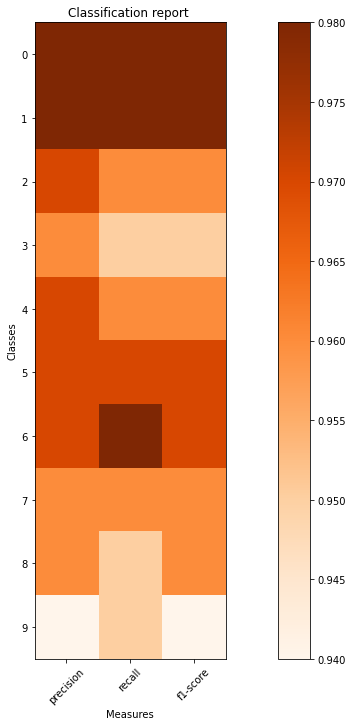

In [ ]:
plot_classification_report(classification_report(y_test, y_p))

###Feature importances

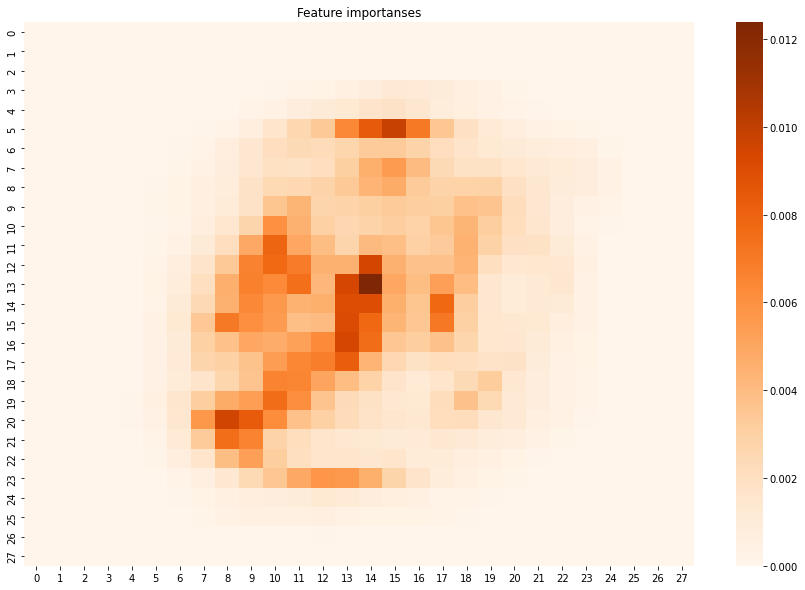

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
snus.heatmap(clf.feature_importances_.reshape(28, 28), annot=False, 
            cmap='Oranges')
plt.title('Feature importances')
plt.show()

Obviously, as expected, the most important pixel is the one in the center, while the other most important pixels are in about the same radius from the central pixel.

# Task 2

### **Gradient Boosting**

We import the function from the library:

In [ ]:
from hyperband_multithreading.models.classification.gb import HBGradientBoostingClassifier

In [ ]:
gb = HBGradientBoostingClassifier(new_data)

In [ ]:
hb_gb = Hyperband(gb)

We start the search for optimal solutions. Since we trained all this before, we recorded the results of the model in the appropriate files. let's see what we have:

In [ ]:
results = hb_gb.run('gb_backup.bck') 

This process spent about **10 hours.**

Whereas each iteration was spent about **5-15 min**

Let's see the results of this process:


In [ ]:
!wget https://www.dropbox.com/s/igkhrsclpm8lzac/results_gb.pckl

--2021-12-17 23:38:36--  https://www.dropbox.com/s/igkhrsclpm8lzac/results_gb.pckl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/igkhrsclpm8lzac/results_gb.pckl [following]
--2021-12-17 23:38:36--  https://www.dropbox.com/s/raw/igkhrsclpm8lzac/results_gb.pckl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d826d8a79b390eda74b92e72f.dl.dropboxusercontent.com/cd/0/inline/BcDNwsI6dhnxX1XazM-NJpplk_s8iQzGEnnYCYYKbFXSkOQZj1MOrX2O_qv3xJAZ_lZE5KSpshwzeTZndaIzUZoRu5DWHRvGymkvCzDGtXXpzN6Dul9YdCi_ta77oOYcQAchWTEP2oqhP3D5ObeDayj0/file# [following]
--2021-12-17 23:38:37--  https://uc8d826d8a79b390eda74b92e72f.dl.dropboxusercontent.com/cd/0/inline/BcDNwsI6dhnxX1XazM-NJpplk_s8iQzGEnnYCYYKbFXSkOQZj1MOrX2O_qv3xJAZ_lZE5KSpshwzeTZnd

In [ ]:
with open('results_gb.pckl', 'rb') as f:
  results_gb = pickle.load(f)

In [ ]:
gb_hb = min(results_gb, key=lambda x: x['loss'])
gb_hb

{'acc': 0.825595238095238,
 'auc': 0.9935361777285754,
 'counter': 0,
 'iterations': 1.0,
 'log_loss': 0.4840638951762721,
 'loss': 0.4840638951762721,
 'params': {'learning_rate': 0.19226245685059606,
  'max_depth': 9,
  'max_features': None,
  'min_samples_leaf': 6,
  'min_samples_split': 17,
  'subsample': 0.8504401985233483}}

In [ ]:
gb = GradientBoostingClassifier(**gb_hb['params'])

To be more precise, the computer performed this iteration for more than **45 minutes!!!!!! FUCK U**

In [ ]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.19226245685059606, max_depth=9,
                           min_samples_leaf=6, min_samples_split=17,
                           subsample=0.8504401985233483)

## **Evaluation**

Now, let's check the metric scores:

In [ ]:
get_score(y_test, gb.predict(X_test), gb.predict_proba(X_test), multiclass = True)

{'accuracy': 0.9697619047619047,
 'f1': 0.9695841574522669,
 'precision': 0.9696379109872874,
 'recall': 0.969603408899079,
 'roc_auc': 0.9992471633296307}

In [ ]:
print_confusion_matrix(y_test, gb.predict(X_test))

Confusion Matrix:
[[842   0   3   0   1   1   3   1   2   0]
 [  0 910   4   2   1   1   2   1   3   0]
 [  0   0 834   3   2   1   2   5   5   5]
 [  0   0   7 850   1   6   0   4   4   7]
 [  0   2   0   0 781   0   4   1   5  17]
 [  0   2   1   6   0 727   5   0   1   2]
 [  4   0   2   0   3  10 814   0   4   0]
 [  1   3  16   3   0   1   0 821   0  13]
 [  1   2   8   7   2   4   3   1 755   8]
 [  2   0   0   5  14   2   0  10   2 812]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       853
           1       0.99      0.98      0.99       924
           2       0.95      0.97      0.96       857
           3       0.97      0.97      0.97       879
           4       0.97      0.96      0.97       810
           5       0.97      0.98      0.97       744
           6       0.98      0.97      0.97       837
           7       0.97      0.96      0.96       858
           8       0.97      0.95      0.

### Confusion matrics

Based on the data of the **Confusion Matrix**, we can say that the classes are confused with each other:

*   4 and 9
*   7 and 2
*   7 and 9


because the value of the corresponding rows and columns in the Confusion Matrix is large enough compared to the rest of the cells, except for the main diagonal. This means that these are errors: false negative and false positive



Compared to **Random Forest**, the number of classes that are confused with each other has decreased, for example, class 9 is less likely to be confused with 7 by the model, and 2 and 3 are less often confused.

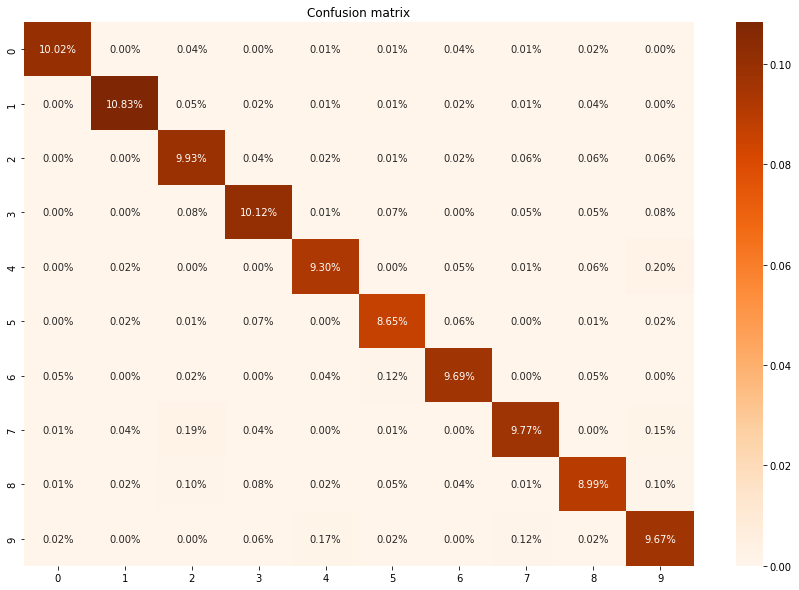

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
snus.heatmap(confusion_matrix(y_test, gb.predict(X_test))/np.sum(confusion_matrix(y_test, gb.predict(X_test))), annot=True, 
            fmt='.2%', cmap='Oranges')
plt.title('Confusion matrix')
plt.show()

### Classification Report

Based on the **Classification Report**, we can say that classes are worst predicted:

*   9, and also 2 and 8,

since the metric values for these classes are minimal. as we can see on graph below:


Changes in the set of classes are visible, which are poorly predictable. For example, this model is better at predicting class 3 compared to **Random Forest**, but much worse at predicting class 2.

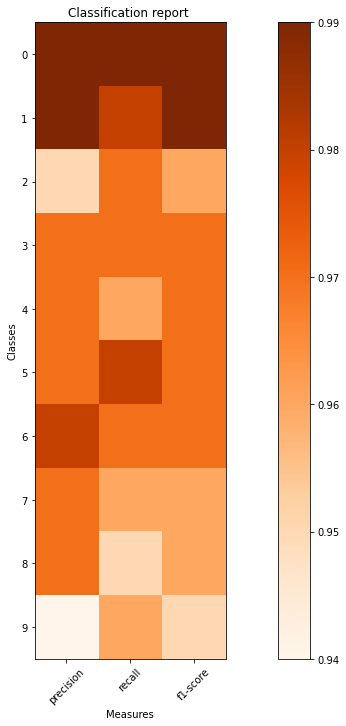

In [ ]:
plot_classification_report(classification_report(y_test, gb.predict(X_test)))

###Feature importances

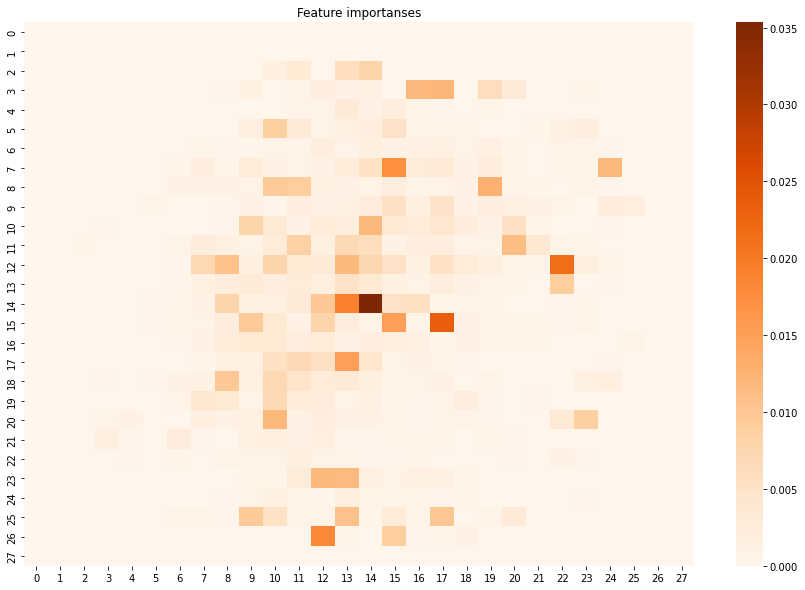

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
snus.heatmap(gb.feature_importances_.reshape(28, 28), annot=False, 
            cmap='Oranges')
plt.title('Feature importances')
plt.show()

Compared to **Random Forest**, it can be easy to see that the central pixel is still dominant, while the so obvious circle around it has dissolved quite strongly. Significant features have become much less, however, the Gradient Boosting model is not inferior to Random Forest in accuracy.

## **XGBoost**

This is the longest and heaviest of the classifiers, because the computer crashed when there were more than two flows.
Estimated operating time more than **15 hours**

In [ ]:
from hyperband_multithreading.models.classification.xgb import HBXGBoostClassification

In [ ]:
xgb = HBXGBoostClassification(new_data)

In [ ]:
hb_xgb = Hyperband(xgb)

We start the search for optimal solutions. Since we trained all this before, we recorded the results of the model in the appropriate files. let's see what we have:

In [ ]:
results = hb_xgb.run('xgb_backup.bck') 

Each iteration spent about 30 min

In [ ]:
!wget https://www.dropbox.com/s/bzvf2gflp58qqzl/results_xgb.pckl

--2021-12-18 00:39:34--  https://www.dropbox.com/s/bzvf2gflp58qqzl/results_xgb.pckl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bzvf2gflp58qqzl/results_xgb.pckl [following]
--2021-12-18 00:39:34--  https://www.dropbox.com/s/raw/bzvf2gflp58qqzl/results_xgb.pckl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8f2d56b2b86d29872a7da92c2b.dl.dropboxusercontent.com/cd/0/inline/BcAv0QlPg4l3-dObRcT332D-nYdOvQ-lheV9RIrrvxTFLt_SbYXzNYvo07iT23mwqY0L1yr_zMAFw0xln1LWx-7rufbKvi82JGg-ljb5EDThNWCvNx-SgDEWYjOiuzWzPlMPm4Lu293Rjl-j8PQ6paAC/file# [following]
--2021-12-18 00:39:35--  https://uc8f2d56b2b86d29872a7da92c2b.dl.dropboxusercontent.com/cd/0/inline/BcAv0QlPg4l3-dObRcT332D-nYdOvQ-lheV9RIrrvxTFLt_SbYXzNYvo07iT23mwqY0L1yr_zMAFw0

In [ ]:
with open('results_xgb.pckl', 'rb') as f:
  results_xgb = pickle.load(f)

In [ ]:
# xgb_hb = min(results_xgb, key=lambda x: x['loss'])
xgb_hb = results_xgb
xgb_hb

{'base_score': 0.5704040667966356,
 'colsample_bylevel': 0.9504035424691654,
 'colsample_bytree': 0.631734614762781,
 'gamma': 0.26524957708085595,
 'learning_rate': 0.17701602154439788,
 'max_depth': 9,
 'min_child_weight': 7,
 'reg_alpha': 3.339356619104281e-07,
 'reg_lambda': 6.280995819859092,
 'subsample': 0.8554297434408441}

In [ ]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier(**xgb_hb)

This model below was training during **15 minutes**:

In [ ]:
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5704040667966356,
              colsample_bylevel=0.9504035424691654,
              colsample_bytree=0.631734614762781, gamma=0.26524957708085595,
              learning_rate=0.17701602154439788, max_depth=9,
              min_child_weight=7, objective='multi:softprob',
              reg_alpha=3.339356619104281e-07, reg_lambda=6.280995819859092,
              subsample=0.8554297434408441)

## **Evaluation**

Now, let's check the metric scores:

In [ ]:
get_score(y_test, xgb_cl.predict(X_test), xgb_cl.predict_proba(X_test), multiclass = True)

{'accuracy': 0.9720238095238095,
 'f1': 0.9719613334718792,
 'precision': 0.971991187458821,
 'recall': 0.9719673484320437,
 'roc_auc': 0.999444953164013}

In [ ]:
print_confusion_matrix(y_test, xgb_cl.predict(X_test))

Confusion Matrix:
[[845   0   1   0   2   0   2   0   2   1]
 [  0 912   4   3   1   0   1   0   2   1]
 [  1   4 825   5   3   0   1  11   4   3]
 [  2   1   7 847   1   6   1   3   5   6]
 [  1   1   0   0 782   0   4   2   5  15]
 [  2   2   1   4   0 728   3   0   1   3]
 [  6   0   1   0   1   7 820   0   2   0]
 [  0   4  10   2   3   0   0 824   2  13]
 [  2   2   3   6   2   2   2   1 766   5]
 [  3   0   0   5  14   1   0   6   2 816]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       853
           1       0.98      0.99      0.99       924
           2       0.97      0.96      0.97       857
           3       0.97      0.96      0.97       879
           4       0.97      0.97      0.97       810
           5       0.98      0.98      0.98       744
           6       0.98      0.98      0.98       837
           7       0.97      0.96      0.97       858
           8       0.97      0.97      0.

### Confusion matrics

Based on the data of the **Confusion Matrix**, we can say that the classes are confused with each other:

*   4 and 9
*   7 and 2
*   7 and 9

because the value of the corresponding rows and columns in the Confusion Matrix is large enough compared to the rest of the cells, except for the main diagonal. This means that these are errors: false negative and false positive



**XGBoost** is similar to Gradient Boosting in this regard, because the classes that get confused are the same.

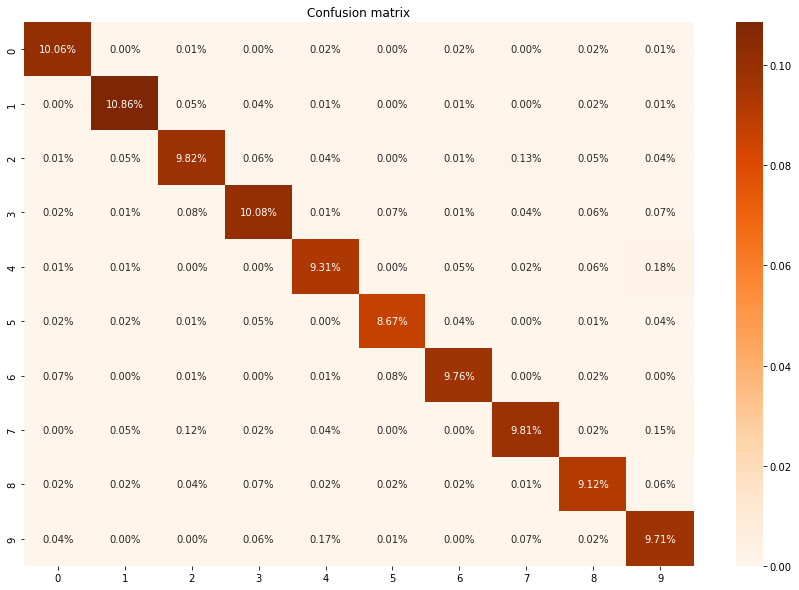

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
snus.heatmap(confusion_matrix(y_test, xgb_cl.predict(X_test))/np.sum(confusion_matrix(y_test, xgb_cl.predict(X_test))), annot=True, 
            fmt='.2%', cmap='Oranges')
plt.title('Confusion matrix')
plt.show()

### Classification Report

Based on the **Classification Report**, we can say that classes are worst predicted:

*   9, since the metric values for these classes are minimal. as we can see on graph below:
*   2, 3 and 7 are bit more.


We see significant improvements in how grades 2, 3, and 8 are predicted compared to **Random Forest** and **Gradient Boosting**. However, grade 9 is still unresolved and is the worst predictor in each of the models.

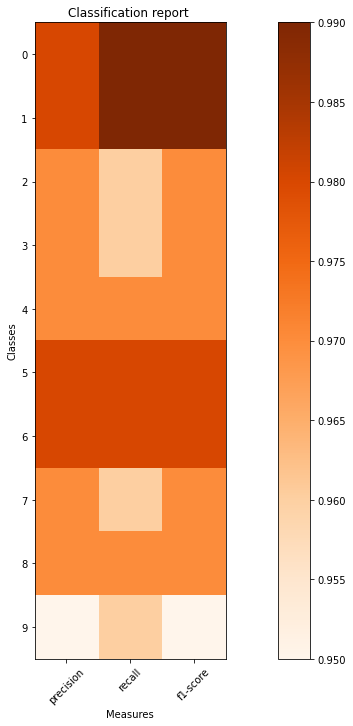

In [ ]:
plot_classification_report(classification_report(y_test, xgb_cl.predict(X_test)))

###Feature importances

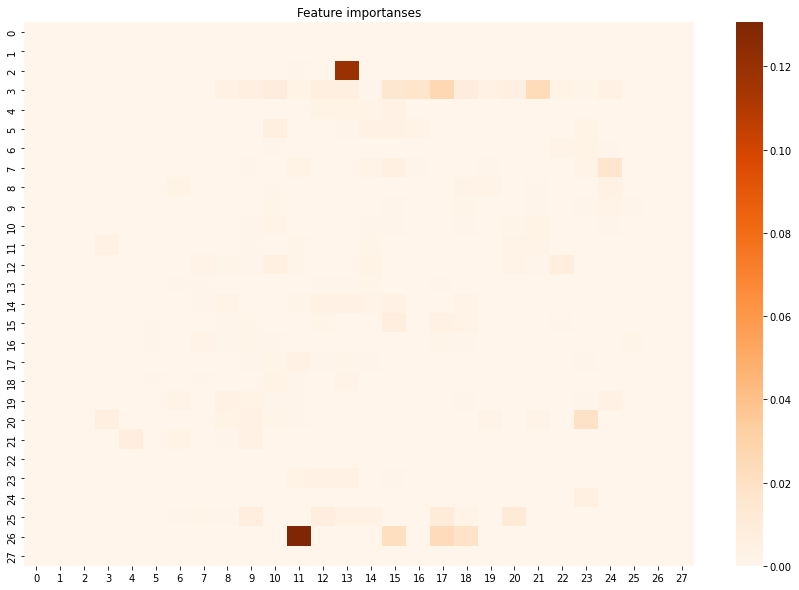

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
snus.heatmap(xgb_cl.feature_importances_.reshape(28, 28), annot=False, 
            cmap='Oranges')
plt.title('Feature importances')
plt.show()

Interestingly enough, in XGBoost we can see that the number of really significant features is small: **only two**. 

There are a small number of features that are slightly more important than 0.1, but there are relatively few of them. 

It is noteworthy that the main features are located at the top and bottom of the image. However, it is this model that has the highest accuracy.

## **Сomparison of models**

We have three models: 


1.   **Random Forest**
2.   **Gradient Boosting**
3.   **XGBoost** 



In [ ]:
models = [
          {
              'model_instance': clf,
              'model_name': 'Random Forest',
              'time': 5
          },
          {
              'model_instance': gb,
              'model_name': 'Gradient Boosting',
              'time': 62
          },
          {
              'model_instance': xgb_cl,
              'model_name': 'XGBoost',
              'time': 18
          },

]


results = print_score_table(X_test, y_test, models, True)
results

,Model,Time (min),accuracy,f1,precision,recall,roc_auc
0,Random Forest,5,0.964048,0.963881,0.963909,0.963872,0.999024
1,Gradient Boosting,62,0.970952,0.970831,0.970961,0.970781,0.999291
2,XGBoost,18,0.972024,0.971961,0.971991,0.971967,0.999445


As we can see, **XGBoost** shows the best metric values compared to other models, but it is not the fastest. **Random Forest**, which is the fastest to learn, shows the worst metrics. And **Gradient Boosting** takes an incredibly long time to train and shows the average values of the metrics.